### RWALK blog post
This notebook is the basis for a more exhaustive blog post at [lukaskoestler.com](https://lukaskoestler.com/blog/random_walk.html). The notebook should be read accompanied by the blog post which should also be considered the primary documentation for this repository.

In [11]:
import numpy as np
import rwalk
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import os
import multiprocessing
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

%matplotlib notebook

Networkx version: 2.2


In [2]:
def nx_random_walk(G, num_walks=10, num_steps=3):
    walks = list()
    for i in G.nodes():
        for walk in range(num_walks):
            curr_walk = [i]
            curr = i
            for step in range(num_steps):
                neighbors = list(G.neighbors(curr))
                if len(neighbors) > 0:
                    curr = random.choice(neighbors)
                curr_walk.append(curr)
            walks.append(curr_walk)
    return walks

In [3]:
seed = 111413
n = 20000
avg_deg = 50
p = avg_deg / n
G = nx.fast_gnp_random_graph(n, p, seed=seed)
nx.write_edgelist(G, "test.edgelist", data=False)
ptr, neighs = rwalk.read_edgelist("test.edgelist")

In [4]:
num_walks = 10
num_steps = 30

In [17]:
# First loop for warm up
for _ in range(5):
    starttime = time()
    walks = nx_random_walk(G, num_walks=num_walks, num_steps=num_steps)
    time_nx = time() - starttime

In [13]:
# Inner loop for warm up
n_cpus = np.arange(1, multiprocessing.cpu_count()+1)
times = np.zeros(shape=n_cpus.shape, dtype=np.float)
for i, nthread in enumerate(n_cpus):
    for _ in range(5):
        starttime = time()
        walks = rwalk.random_walk(ptr, neighs, num_walks=num_walks, num_steps=num_steps, nthread=nthread, seed=seed)
        times[i] = time() - starttime

In [18]:
print("Speedup over nx serial   ca {:3d}".format(int(time_nx / times[0])))
print("Speedup over nx parallel ca {:3d}".format(int(time_nx / times[-1])))

Speedup over nx serial   ca 108
Speedup over nx parallel ca 559


In [15]:
# Ahmdal
T1 = times[0]
ps = (n_cpus[1:] / (n_cpus[1:]-1)) * (1 - times[1:]/T1)
p = np.mean(ps)

print("Estimated parallel fraction {:6.3f}%".format(p*100))

Estimated parallel fraction 96.440%


<IPython.core.display.Javascript object>


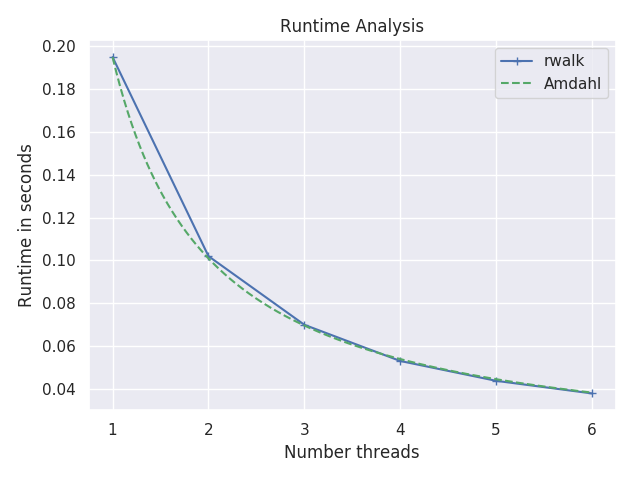

In [19]:
nn = np.linspace(n_cpus[0], n_cpus[-1], 500)
plt.figure()
plt.plot(n_cpus, times, '+-', label="rwalk")
plt.plot(nn, (1-p)*T1 + p*T1/nn, 'g--', label="Amdahl")
plt.legend()
plt.title("Runtime Analysis")
plt.xlabel("Number threads")
plt.ylabel("Runtime in seconds")
plt.show()

plt.tight_layout()
plt.savefig("runtime.svg")